In [1]:
import sys
# not best practice, but makes it easier to import from subdirectory
sys.path.insert(0, './lib')

import experiment as exp
import plot
import predict

import numpy as np
import matplotlib.pyplot as plt

import os
import torch

_ = plt.rcParams['axes.grid'] = False # turn off grid

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0')

Invoking __init__.py for NDNT.utils


In [56]:
# load experiment 10 (different activity reg values and weight regs)
e10 = exp.load('reg_experiment_10', experiment_location='experiments', datadir='Mdata')
e10.trials_df

,null_adjusted_LL,num_filters,num_inh_percent,expt,kernel_widths,kernel_heights,copy_weights,freeze_weights,include_MUs,is_multiexp,batch_size,modelstr,activity,d2xt,center,bcs,name,trial,mean_LLs
0,True,"16,8,8",0.5,expt04,"21,11,5","3,3,3",False,False,False,False,6000,cnim_scaffold,1.00,0.01,0.01,{'d2xt': 1},cnim_scaffold0,<experiment.Trial object at 0x7f0e1a258370>,0.400337
0,True,"16,8,8",0.5,expt04,"21,11,5","3,3,3",False,False,False,False,6000,cnim_scaffold,0.75,0.01,0.01,{'d2xt': 1},cnim_scaffold1,<experiment.Trial object at 0x7f0e1a16fd00>,0.387322
0,True,"16,8,8",0.5,expt04,"21,11,5","3,3,3",False,False,False,False,6000,cnim_scaffold,0.50,0.01,0.01,{'d2xt': 1},cnim_scaffold2,<experiment.Trial object at 0x7f0e1a1a8640>,0.380576
0,True,"16,8,8",0.5,expt04,"21,11,5","3,3,3",False,False,False,False,6000,cnim_scaffold,0.25,0.01,0.01,{'d2xt': 1},cnim_scaffold3,<experiment.Trial object at 0x7f0e1a0b81c0>,0.432095
0,True,"16,8,8",0.5,expt04,"21,11,5","3,3,3",False,False,False,False,6000,cnim_scaffold,0.10,0.01,0.01,{'d2xt': 1},cnim_scaffold4,<experiment.Trial object at 0x7f0e1a261fd0>,0.450950
0,True,"16,8,8",0.5,expt04,"21,11,5","3,3,3",False,False,False,False,6000,cnim_scaffold,0.00,0.01,0.01,{'d2xt': 1},cnim_scaffold5,<experiment.Trial object at 0x7f0e1a178fa0>,0.499502


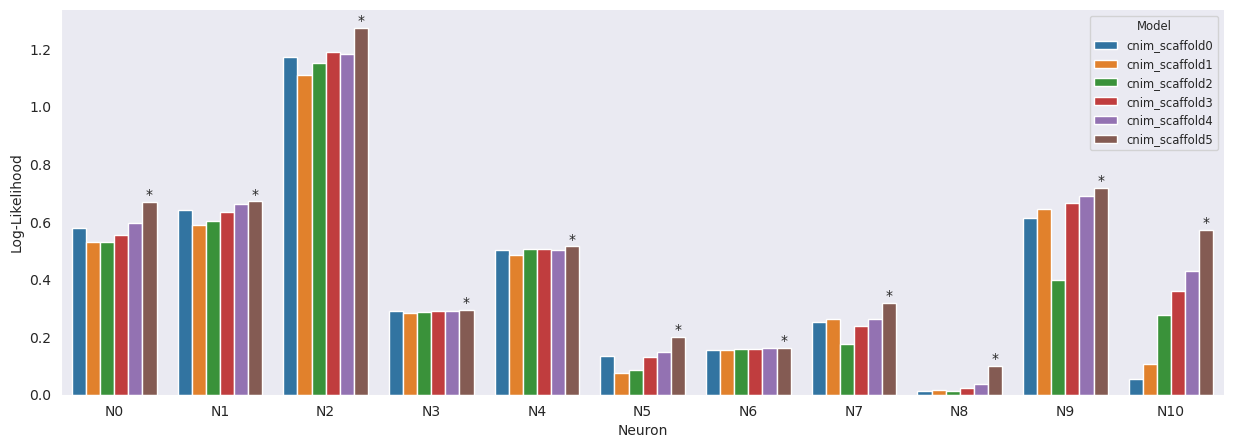

In [78]:
e10.plot_LLs()

activity = 1.0


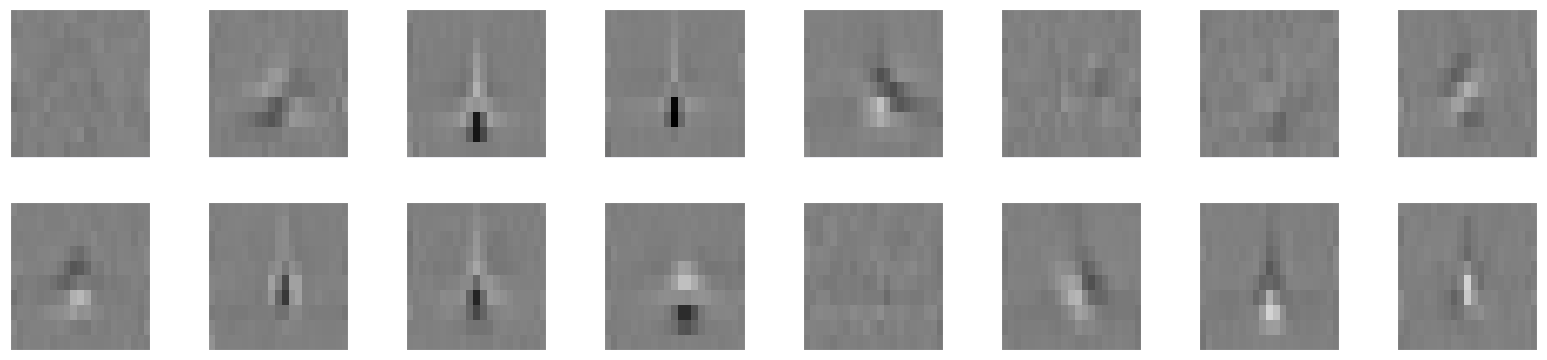

activity = 0.75


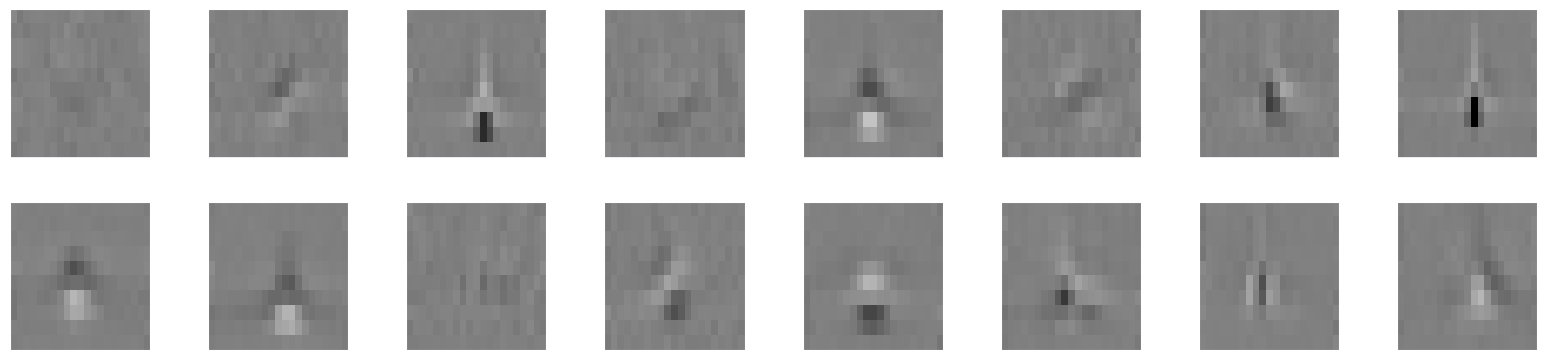

activity = 0.5


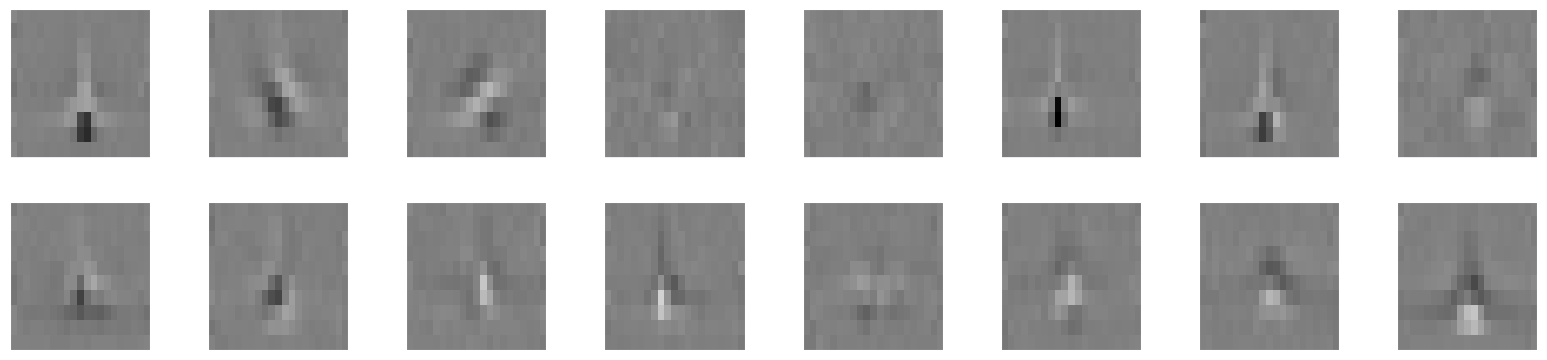

activity = 0.25


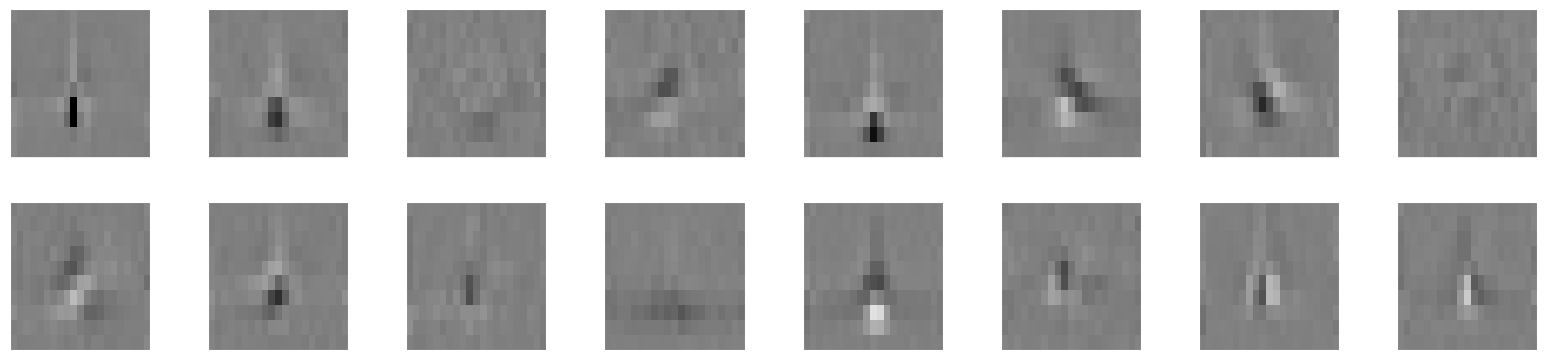

activity = 0.1


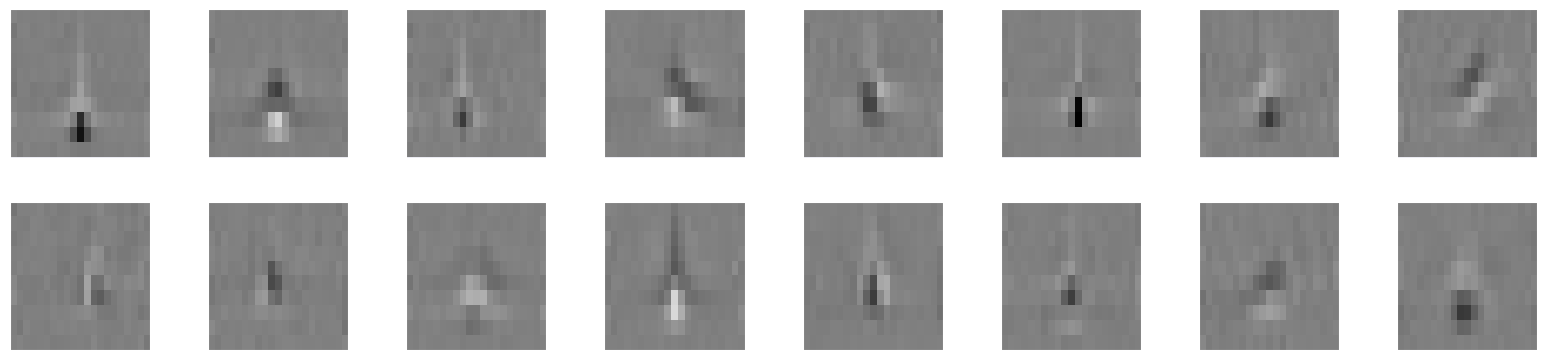

activity = 0.0


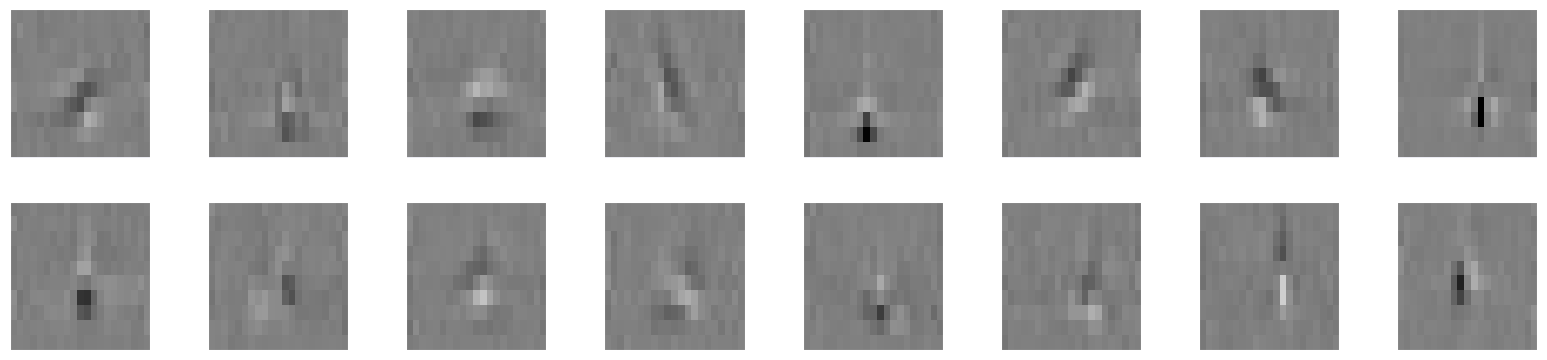

In [65]:
# plot the filters for each trial
for trial in e10.trials:
    print('activity =', trial.trial_params['activity'])
    trial.model.NDN.plot_filters()

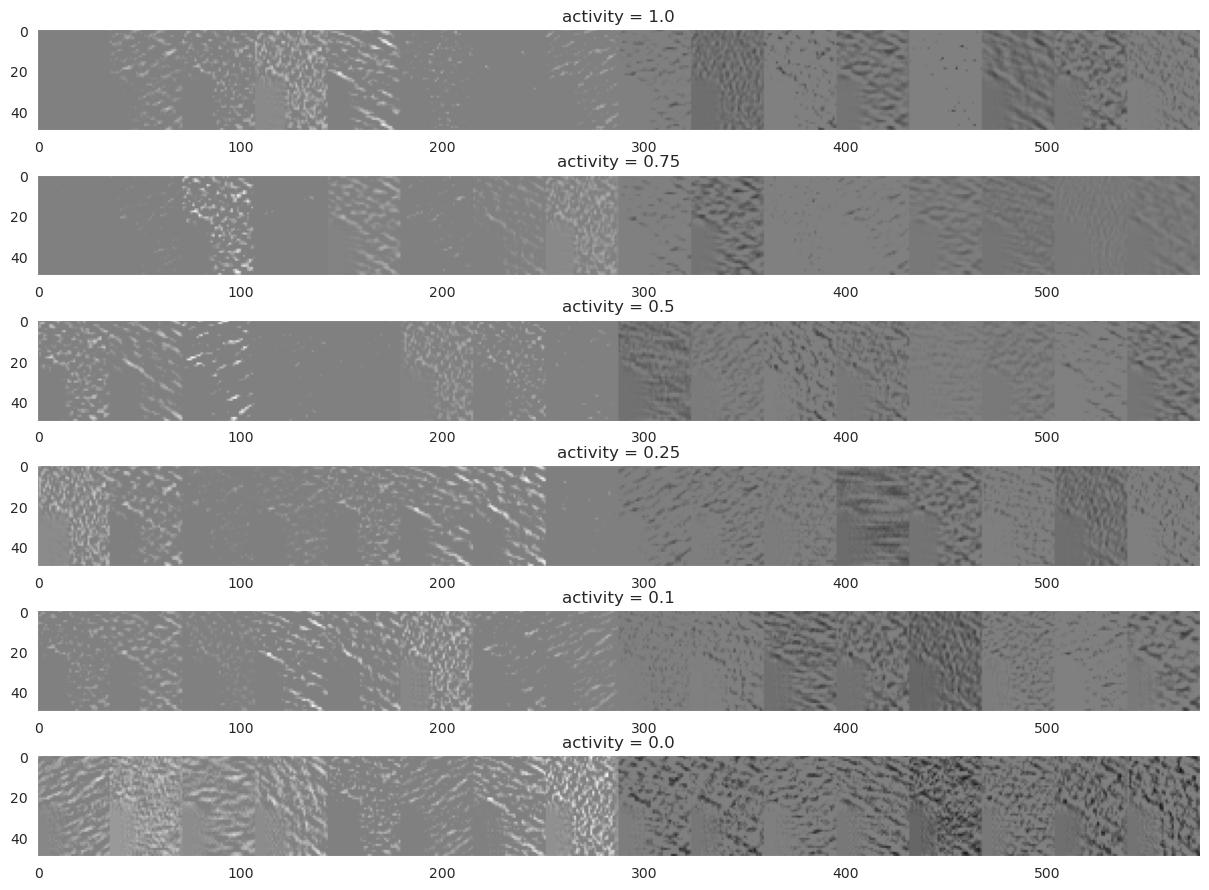

In [75]:
plot.plot_activity(e10.trials, title_param='activity', 
                   start=0, end=50, figsize=(15,11))

# cluster the activity

In [233]:
# get the activity for some stimuli for each trial
start = 0
end   = 50000 

trial_activities = []

for trial in e10.trials:
    model = trial.model
    trial_activity = predict.predict(model,
                              dataset=trial.dataset[start:end],
                              network_names_to_use=['core'],
                              calc_jacobian=False)
    trial_activities.append((trial, trial_activity))

In [234]:
# get the weights going from layer 1 to the readout layer for a particular neuron
weighted_trial_activities = []

for trial, trial_activity in trial_activities:
    readout = trial.model.networks_by_name['readout'].layers[0].weights.reshape(1152, 11)
    weighted_activities = np.zeros((end-start, 11, 1152))
    for frame in range(0, end-start):
        activity = np.squeeze(np.concatenate([trial_activity.outputs[frame]['core'][i] for i in range(3)], axis=1))
        # reweight the activations by the weights by element-wise multiplication
        for neuron in range(11):
            weighted_activity = activity * readout[:, neuron]
            weighted_activities[frame, neuron, :] = weighted_activity
    weighted_trial_activities.append((trial, readout, weighted_activities))

In [235]:
weighted_trial_activities[0][1].shape, weighted_trial_activities[0][2].shape, weighted_trial_activities[0][1].T.shape

((1152, 11), (50000, 11, 1152), (11, 1152))

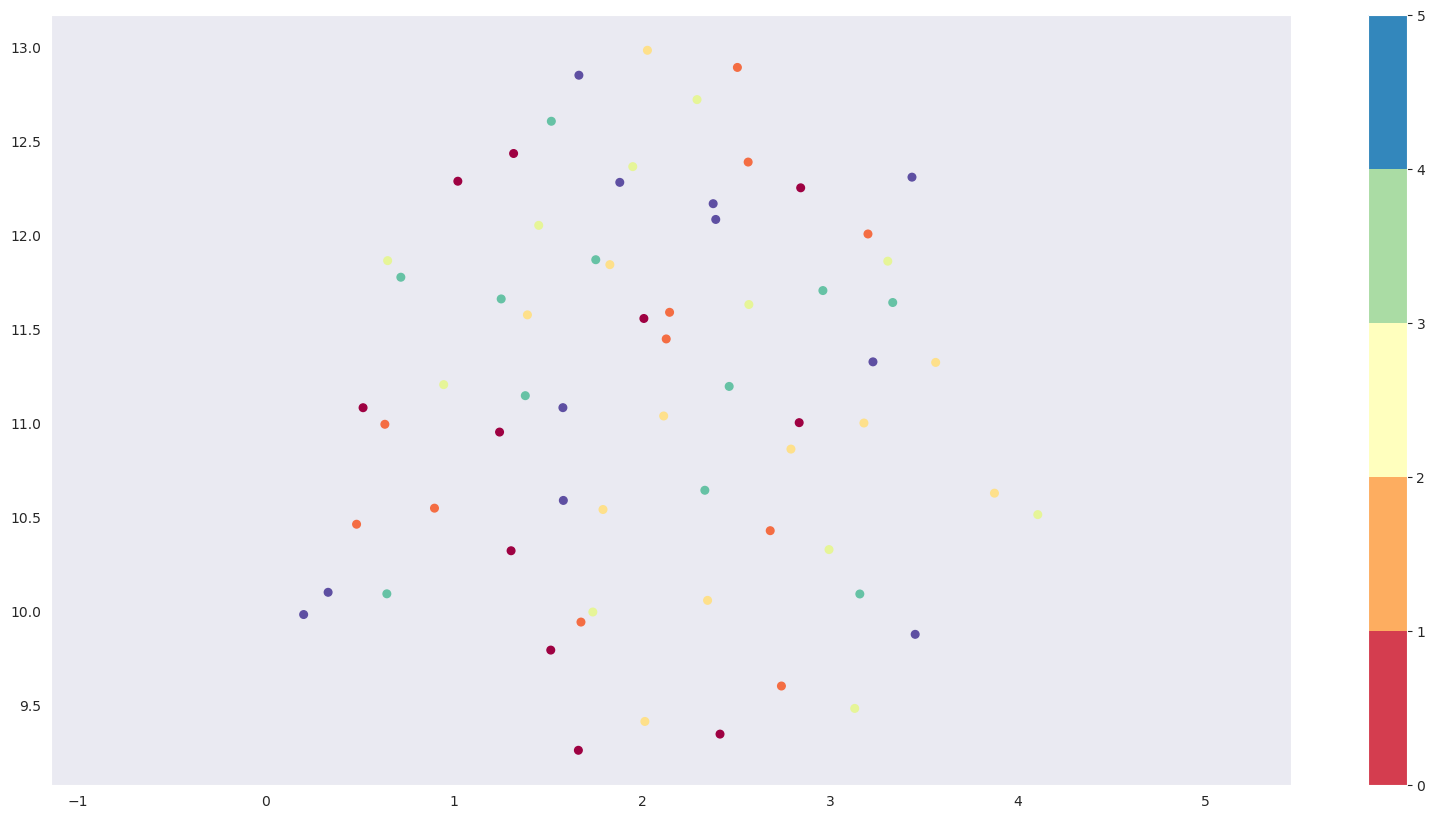

In [226]:
import umap

trial_readout_weights = np.zeros((66, 1152))
i = 0
for trial, readout, weighted_trial_activity in weighted_trial_activities:
    trial_readout_weights[i:i+11,:] = readout.T
    i += 11

reducer = umap.UMAP()
embedding = reducer.fit_transform(trial_readout_weights)
# plot the embeddings, color by neuron
fig = plt.figure(figsize=(20,10))
plt.scatter(embedding[:, 0], embedding[:, 1], c=np.tile(np.arange(6), 11), cmap='Spectral', s=30)
plt.gca().set_aspect('equal', 'datalim')
# plot the colorbar
cbar = plt.colorbar(boundaries=np.arange(6))
plt.show()

# TODO: this is nothing, I need to fix this and figure it out

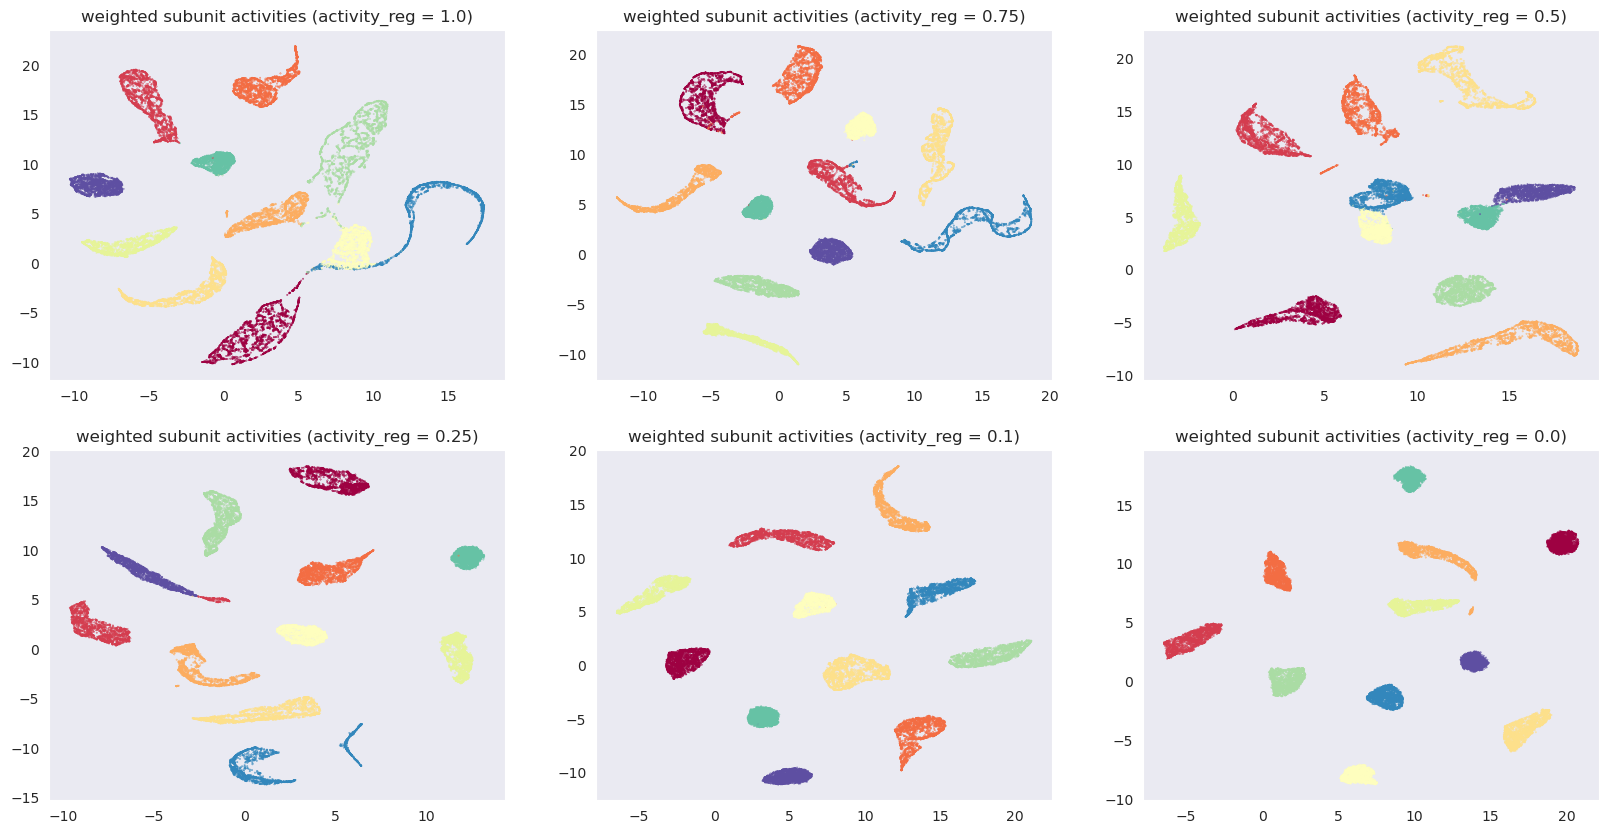

In [227]:
import umap

# make a GridSpec with 2 rows and 1 column
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(2,3)

for i, (trial, readout, weighted_trial_activity) in enumerate(weighted_trial_activities):
    # reshape weighted activities to be 2D (across neurons)
    weighted_activities = weighted_trial_activity.reshape(end-start * 11, 1152)
    
    # TODO: make sure this is doing what I expect
    # TODO: make the grid plot that Dan suggested (related to this, but different, of course)
    # TODO: if this does work, scale it up to many more neurons
    
    # remove frames that are all 0
    weighted_activities = weighted_activities[~np.all(weighted_activities == 0, axis=1)]
    
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(weighted_activities)
    
    # plot the embeddings, color by neuron
    row, col = np.unravel_index(i, (2,3))
    ax = fig.add_subplot(gs[row, col])
    ax.scatter(embedding[:, 0], embedding[:, 1], c=np.tile(np.arange(11), end-start), cmap='Spectral', s=0.1)
    ax.set_title('weighted subunit activities (activity_reg = '+str(trial.trial_params['activity'])+')', fontsize=12)
plt.show()

# make plot comparing layer activity across space

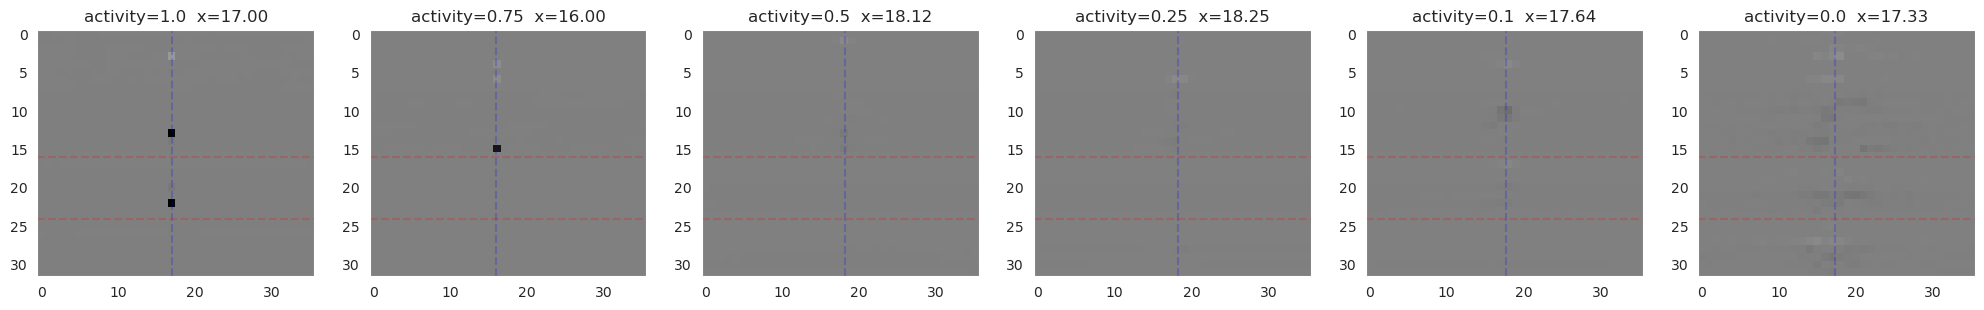

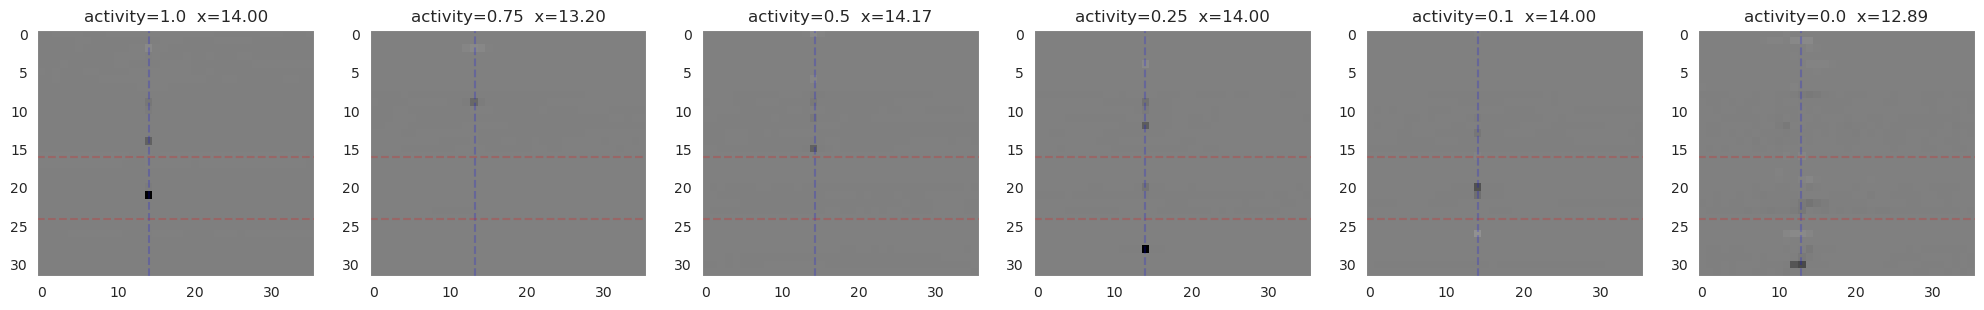

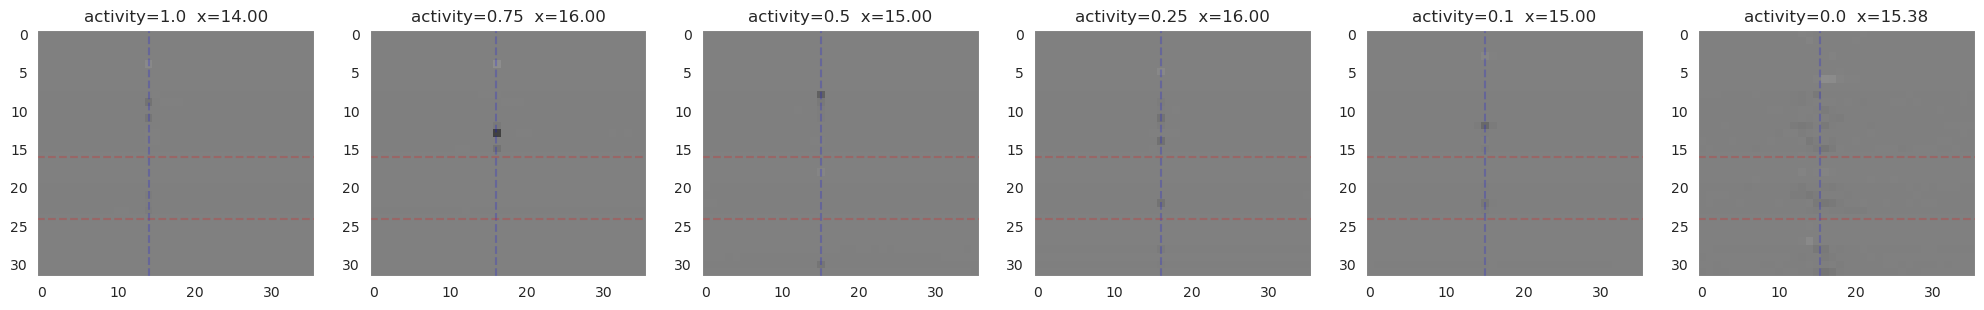

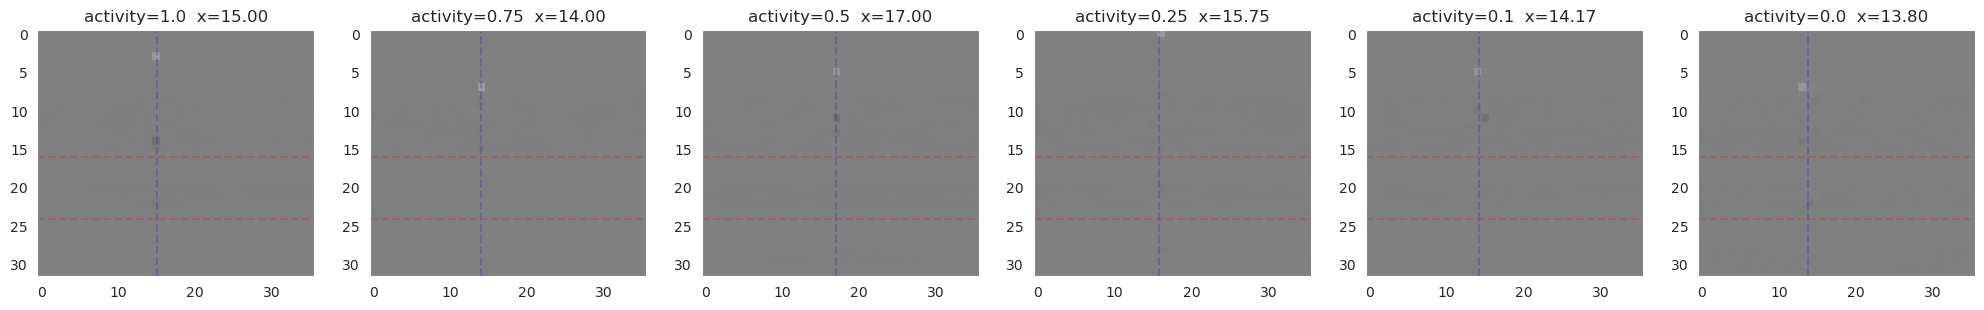

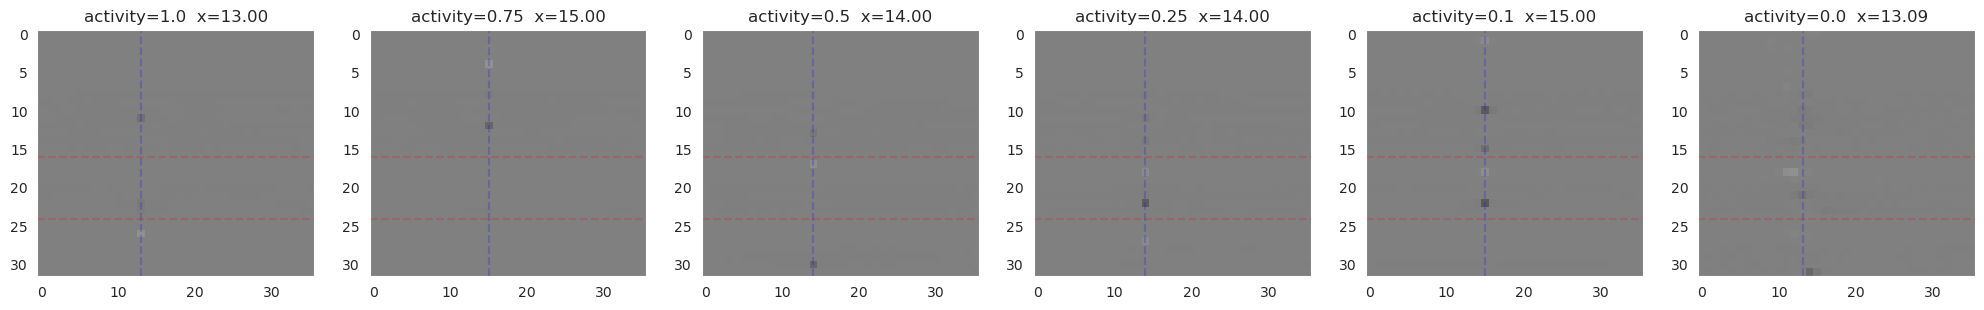

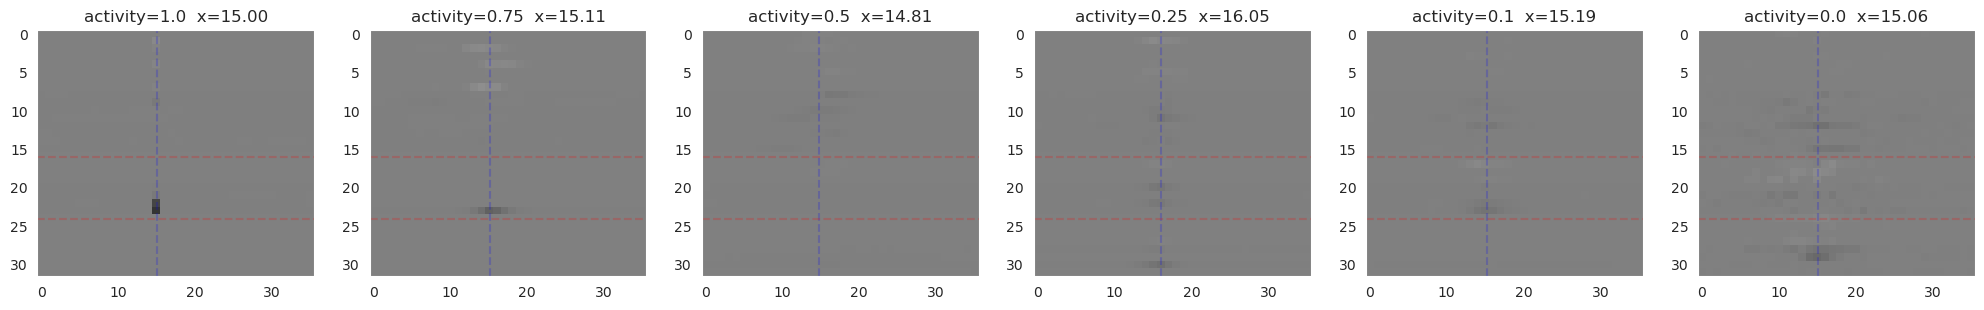

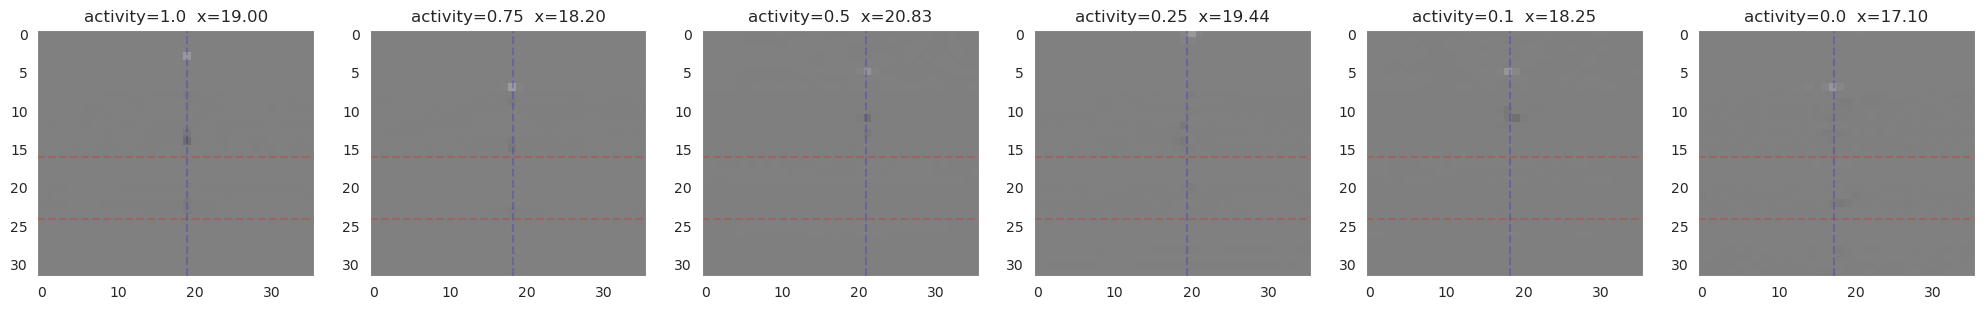

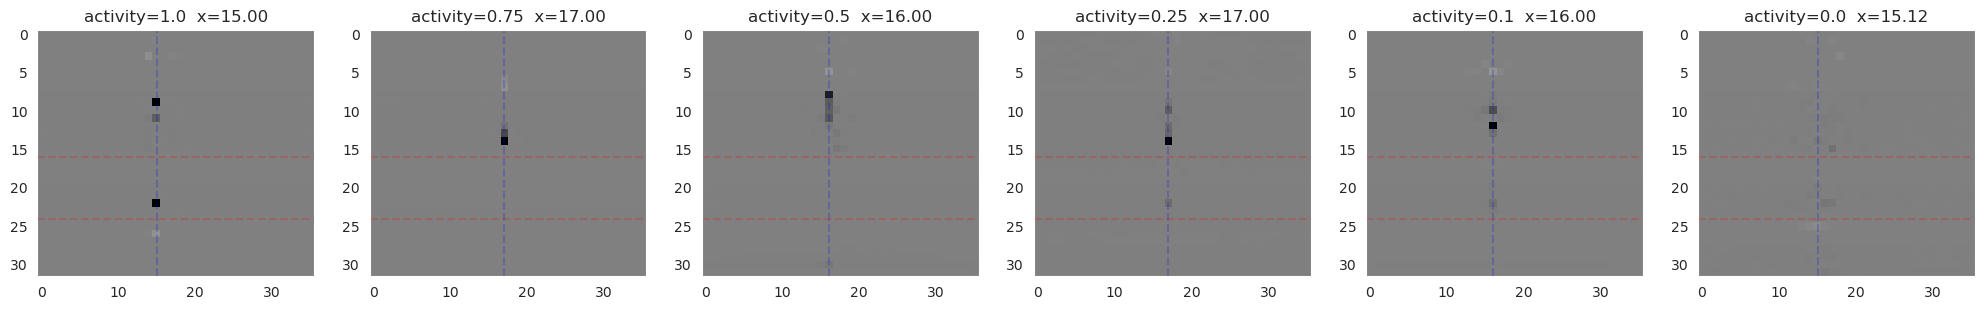

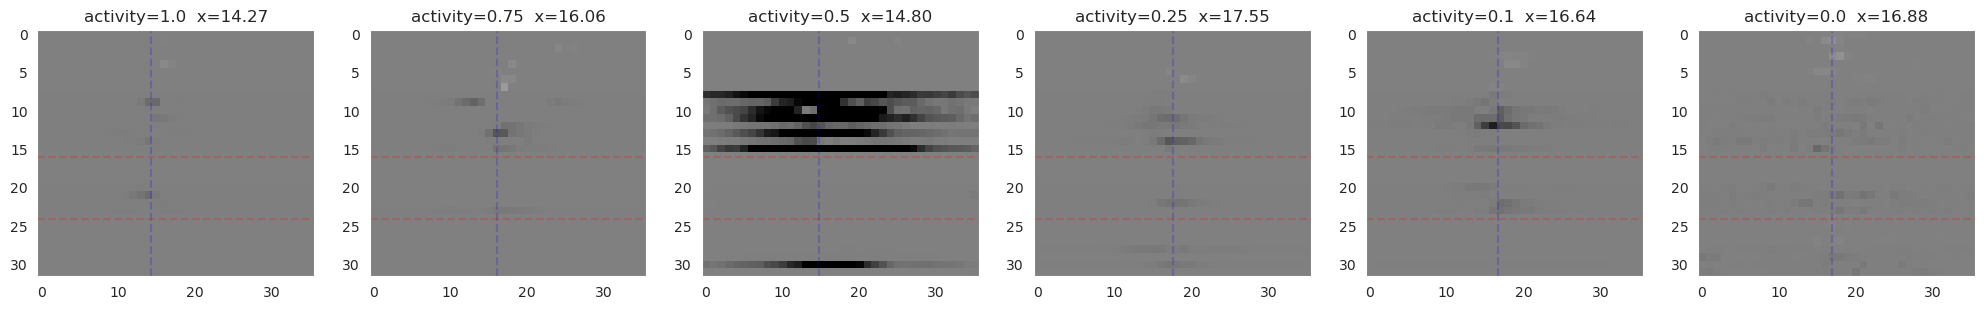

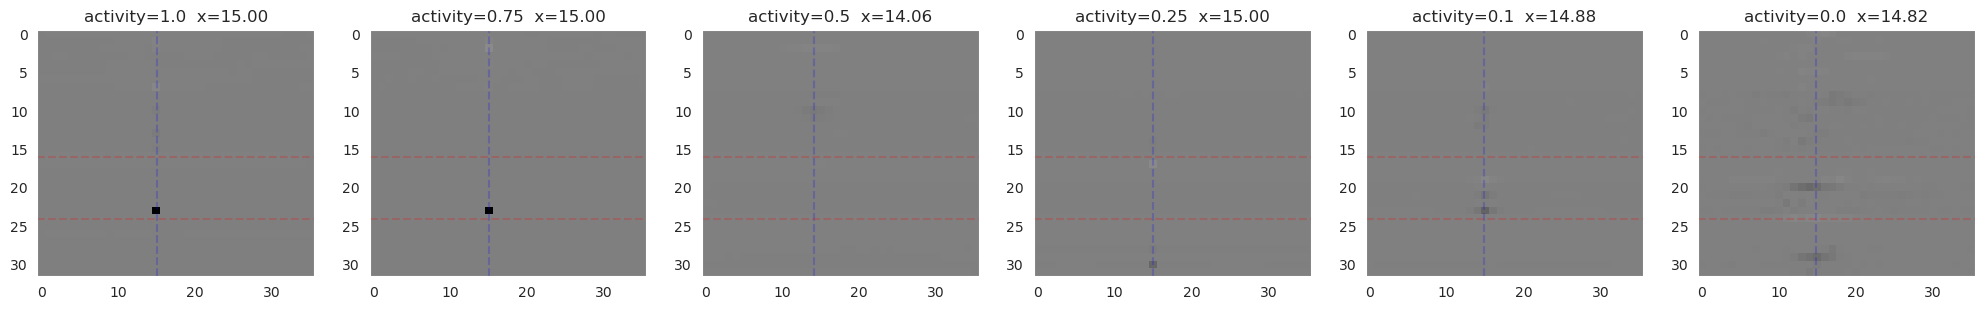

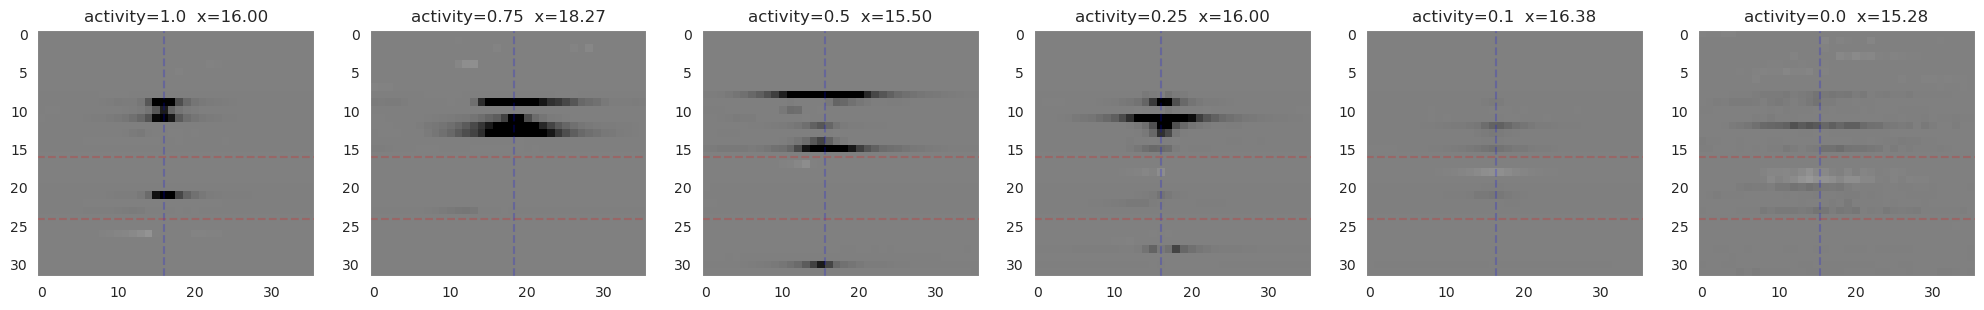

In [237]:
neuron = 1
# calculate the average activation across trials

for neuron in range(11):
    # make a GridSpec with 2 rows and 1 column
    fig = plt.figure(figsize=(25,5))
    gs = fig.add_gridspec(1,6)
    for trial in range(len(e10.trials)):
        centroids = []
        all_weighted_activities = np.zeros((end-start, 1152))
        for frame in range(end-start):
            all_weighted_activities[frame, :] = weighted_trial_activities[trial][2][frame, neuron, :]
            
        # remove empty rows from the all_weighted_activities
        all_weighted_activities = all_weighted_activities[~np.all(all_weighted_activities == 0, axis=1)]
        
        row, col = np.unravel_index(trial, (1,6))
        ax = fig.add_subplot(gs[row, col])
        imax = np.max(all_weighted_activities)
        imin = -imax
        reshaped = np.mean(all_weighted_activities, axis=0).reshape(32,36)
        # find the centroid of the pixels of the reshaped image above the background color
        mean = np.mean(np.abs(reshaped))
        std = np.std(np.abs(reshaped))
        centroids = np.where((np.abs(reshaped) - mean)/std > 3) # find points more than 2 std above the mean
        if len(centroids[0]) > 0:
            centroid = np.mean(centroids, axis=1)
            ax.axvline(x=centroid[1], color='b', linestyle='--', alpha=0.2)
        
        ax.imshow(reshaped, cmap='gray', vmin=imin, vmax=imax)
        # put a horizontal line at y=16 and y=24
        ax.axhline(y=16, color='r', linestyle='--', alpha=0.2)
        ax.axhline(y=24, color='r', linestyle='--', alpha=0.2)
        ax.set_title('activity='+str(e10.trials[trial].trial_params['activity'])+'  x='+'%.2f'%centroid[1], fontsize=12)
    #plt.suptitle('average weighted activity across trials', fontsize=12
    plt.show()

In [238]:
# look over orders of magnitude, and increase until it begins having an effect
# measure sparseness of the activities for each time point
# also look at the sparseness of the weighted activities
# Vinje & Gallant, 2001 - Sparseness of the neural code
# Sparse Coding and Decorrelation in Primary Visual Cortex During Natural Vision